# Library Imports


Install and import the required python libraries

In [1]:
! pip install scikit-plot==0.3.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import  MinMaxScaler
import xarray as xr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input,Dropout
from tensorflow.keras.layers import Conv1D, Conv1DTranspose
from keras.models import load_model
from keras.layers.merge import concatenate

from numpy.fft import fft, ifft, fftfreq, fftshift, ifftshift, fftn, rfftn, ifftn
from sklearn.decomposition import PCA
import scipy.stats as st

from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

from numpy import argmax
from tensorflow.keras.utils import to_categorical
import warnings
import scikitplot as skplt
from operator import itemgetter
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, classification_report

plt.rcParams['figure.dpi'] = 100


# Data Extraction

The data is available at https://github.com/boschresearch/CNC_Machining.git . Hence, cloning the repository and extracting the data.

In [3]:
! git clone https://github.com/boschresearch/CNC_Machining.git

Cloning into 'CNC_Machining'...
remote: Enumerating objects: 1960, done.
remote: Counting objects: 100% (590/590), done.
remote: Compressing objects: 100% (562/562), done.
remote: Total 1960 (delta 24), reused 580 (delta 19), pack-reused 1370
Receiving objects: 100% (1960/1960), 884.32 MiB | 57.41 MiB/s, done.
Resolving deltas: 100% (56/56), done.
Checking out files: 100% (1710/1710), done.


# Data Loading

In [4]:
# Create a folder to store the data
%cd /content/CNC_Machining
%pwd

/content/CNC_Machining


'/content/CNC_Machining'

In [5]:
import os
from utils import data_loader_utils

In [6]:
# Since the file name comprises of Machine name, Operation process No and the 
# anomaly labels as good and bad, data is loaded in iterative manner.
machines = ["M01","M02","M03"]
process_names = ["OP00","OP01","OP02","OP03","OP04","OP05","OP06","OP07","OP08","OP09","OP10","OP11","OP12","OP13","OP14"]


labels = ["good","bad"]
path_to_dataset = "./data/"

In [7]:
X_data = []
y_data = []
for process_name in process_names:
    for machine in machines:
        for label in labels:
            data_path = os.path.join(path_to_dataset, machine, process_name, label)
            data_list, data_label = data_loader_utils.load_tool_research_data(data_path, label=label)
            #concatenating
            X_data.extend(data_list)
            y_data.extend(data_label)

laoding files from ./data/M01/OP00/good... 
laoding files from ./data/M01/OP00/bad... 
laoding files from ./data/M02/OP00/good... 
laoding files from ./data/M02/OP00/bad... 
laoding files from ./data/M03/OP00/good... 
laoding files from ./data/M03/OP00/bad... 
laoding files from ./data/M01/OP01/good... 
laoding files from ./data/M01/OP01/bad... 
laoding files from ./data/M02/OP01/good... 
laoding files from ./data/M02/OP01/bad... 
laoding files from ./data/M03/OP01/good... 
laoding files from ./data/M03/OP01/bad... 
laoding files from ./data/M01/OP02/good... 
laoding files from ./data/M01/OP02/bad... 
laoding files from ./data/M02/OP02/good... 
laoding files from ./data/M02/OP02/bad... 
laoding files from ./data/M03/OP02/good... 
laoding files from ./data/M03/OP02/bad... 
laoding files from ./data/M01/OP03/good... 
laoding files from ./data/M01/OP03/bad... 
laoding files from ./data/M02/OP03/good... 
laoding files from ./data/M02/OP03/bad... 
laoding files from ./data/M03/OP03/good... 

In [8]:
# creating a single dataframe in order to perform EDA and using the 
# same df for data split
y_data = np.array(y_data)
eda_df = pd.DataFrame({'Labels':y_data})
eda_df['MACHINE'] = eda_df['Labels'].astype('string').str[:3]
eda_df['OPERATION PROCESS'] = eda_df['Labels'].astype('string').str[13:17]
eda_df['PROCESS HEALTH'] = ['NOTOK' if 'bad' in i else 'OK' for i in  eda_df['Labels']]
eda_df.head()

,Labels,MACHINE,OPERATION PROCESS,PROCESS HEALTH
0,M01_Aug_2019_OP00_000_good,M01,OP00,OK
1,M01_Aug_2019_OP00_001_good,M01,OP00,OK
2,M01_Aug_2019_OP00_003_good,M01,OP00,OK
3,M01_Aug_2019_OP00_004_good,M01,OP00,OK
4,M01_Aug_2019_OP00_005_good,M01,OP00,OK


# EDA

Text(0.5, 1.0, 'Count of Anomalies present in each machine')

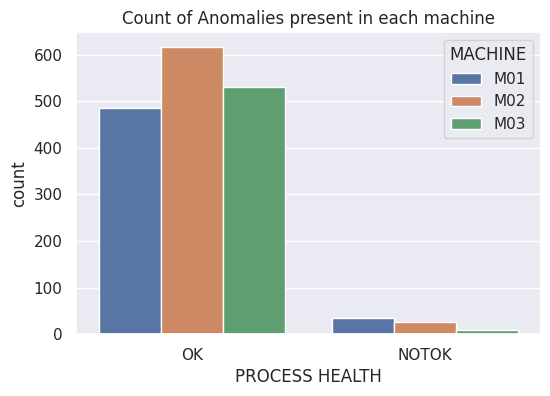

In [9]:
# Analyse the anomalies in machine wise distribution
sns.set(style="darkgrid")
sns.countplot(x='PROCESS HEALTH', data=eda_df, hue='MACHINE')
plt.title('Count of Anomalies present in each machine')

Text(0.5, 1.0, 'Count of Anomalies present during each process')

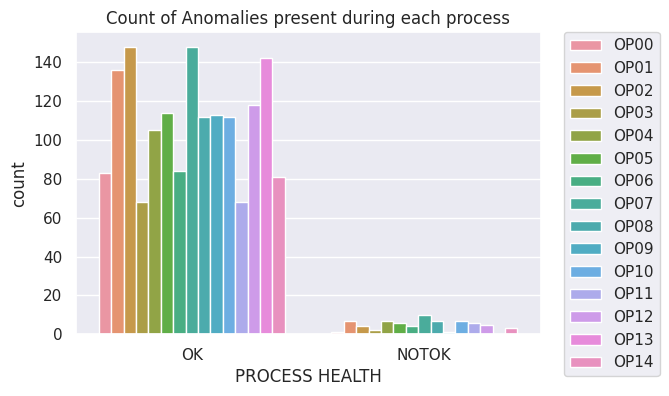

In [10]:
sns.countplot(x='PROCESS HEALTH', data=eda_df, hue='OPERATION PROCESS')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Count of Anomalies present during each process')

In [11]:
# Calculating Mean of each recording of vibrations across all three axis and its distribution
data = np.array(X_data)
all_mean_x = []
all_mean_y = []
all_mean_z = []
for i in X_data:
  all_mean_x.append(i[:,0].mean())
  all_mean_y.append(i[:,1].mean())
  all_mean_z.append(i[:,2].mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Text(0.5, 1.0, 'Distribution of Vibrations Across X-Axis')

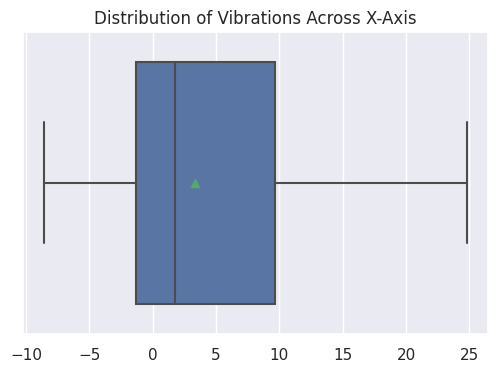

In [12]:
sns.boxplot(x=all_mean_x,  showmeans=True)
plt.title('Distribution of Vibrations Across X-Axis')

Text(0.5, 1.0, 'Distribution of Vibrations Across Y-Axis')

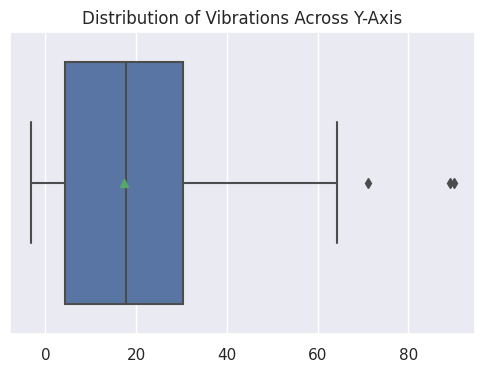

In [13]:
sns.boxplot(x=all_mean_y,  showmeans=True)
plt.title('Distribution of Vibrations Across Y-Axis')

Text(0.5, 1.0, 'Distribution of Vibrations Across Z-Axis')

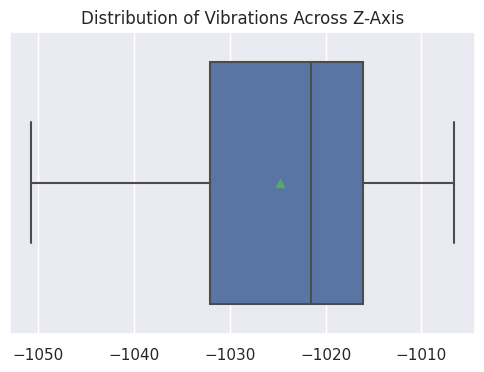

In [14]:
sns.boxplot(x=all_mean_z,  showmeans=True)
plt.title('Distribution of Vibrations Across Z-Axis')

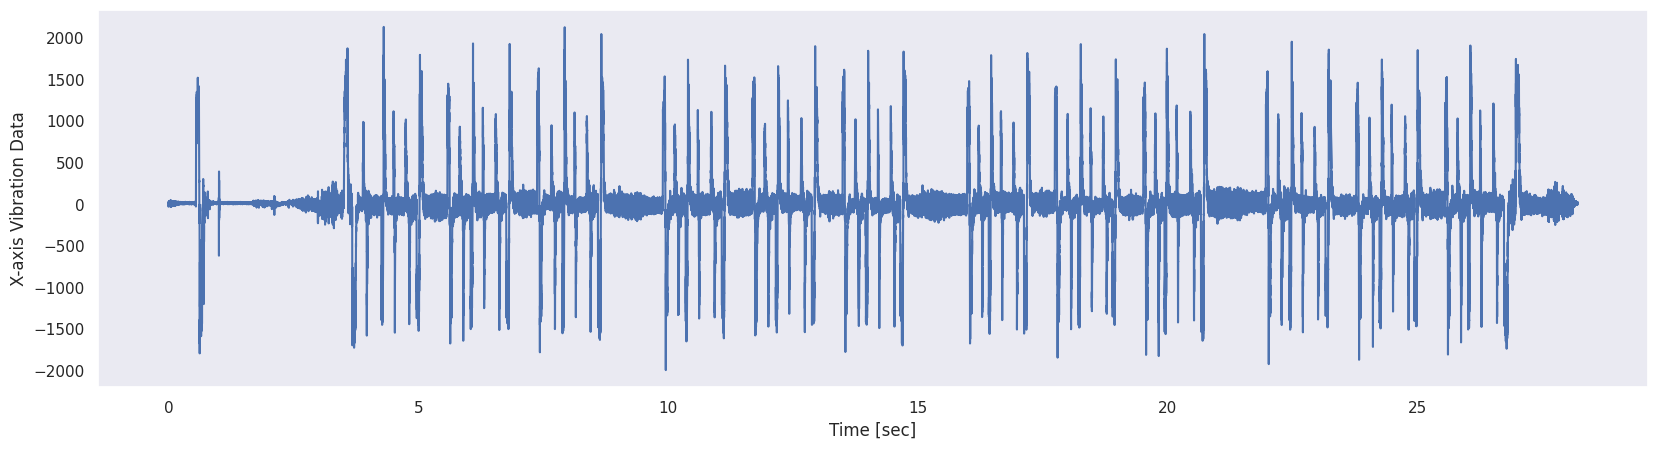

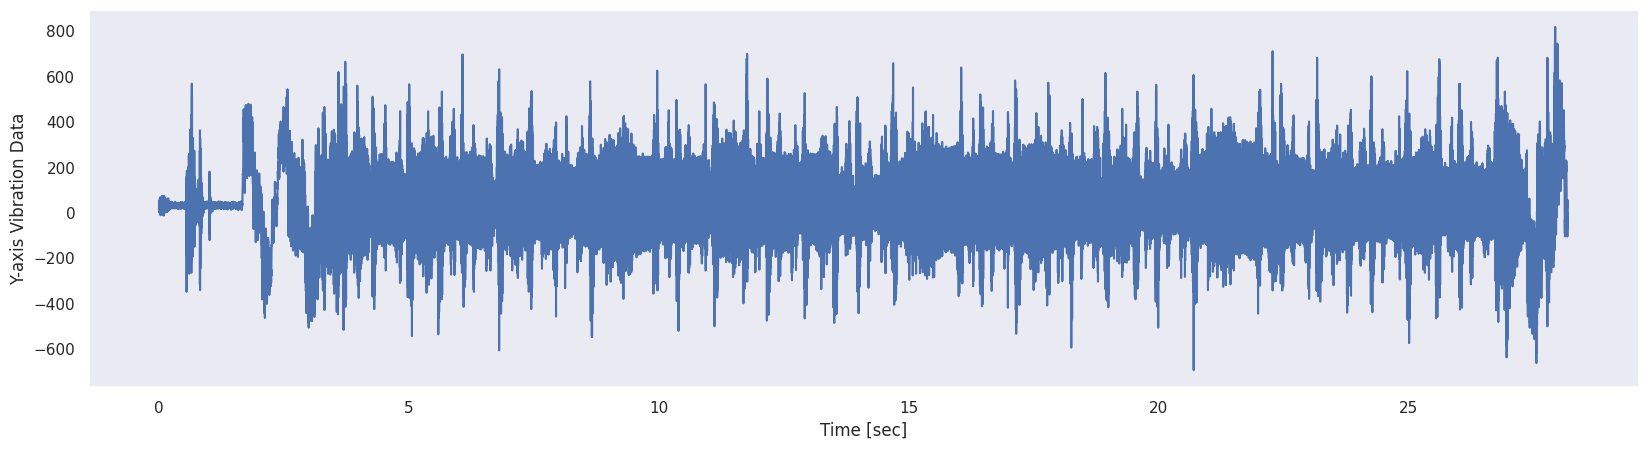

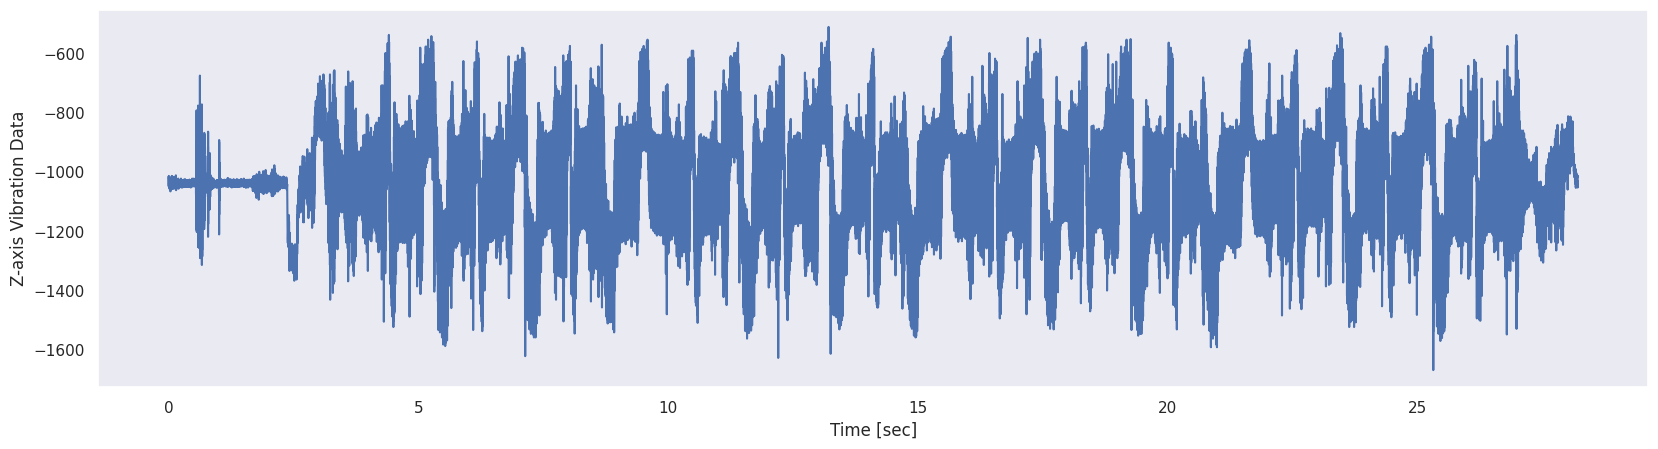

In [15]:
# Time series data of a normal signal
file="./data/M01/OP01/good/M01_Feb_2019_OP01_003.h5"
sample = data_loader_utils.datafile_read(file)

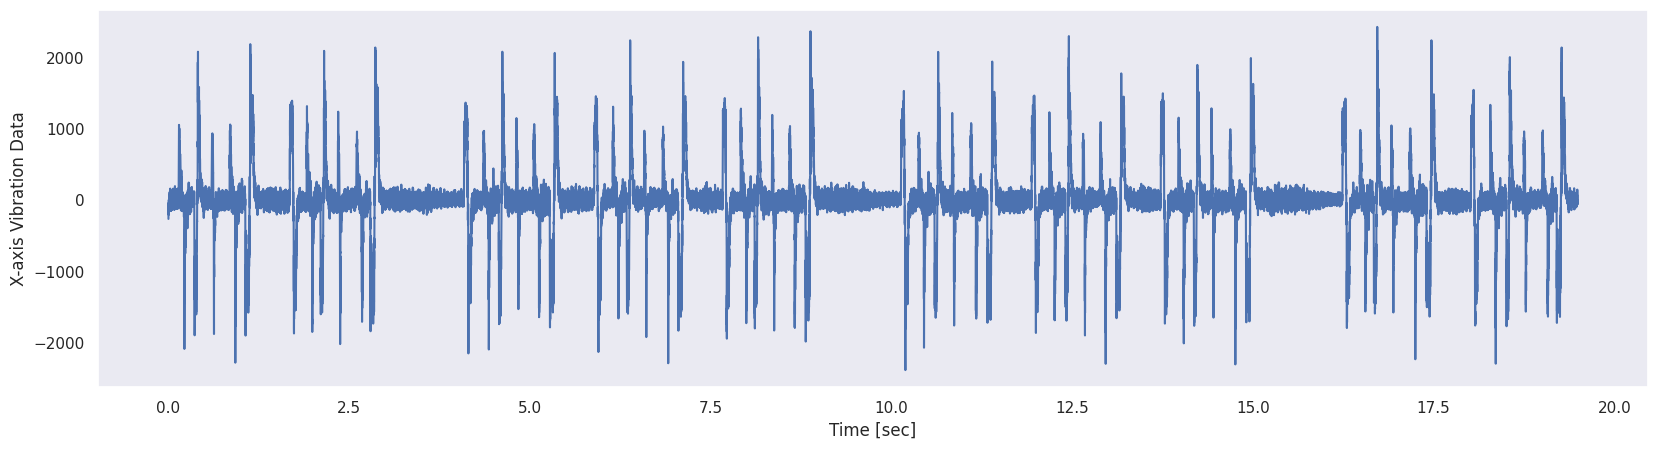

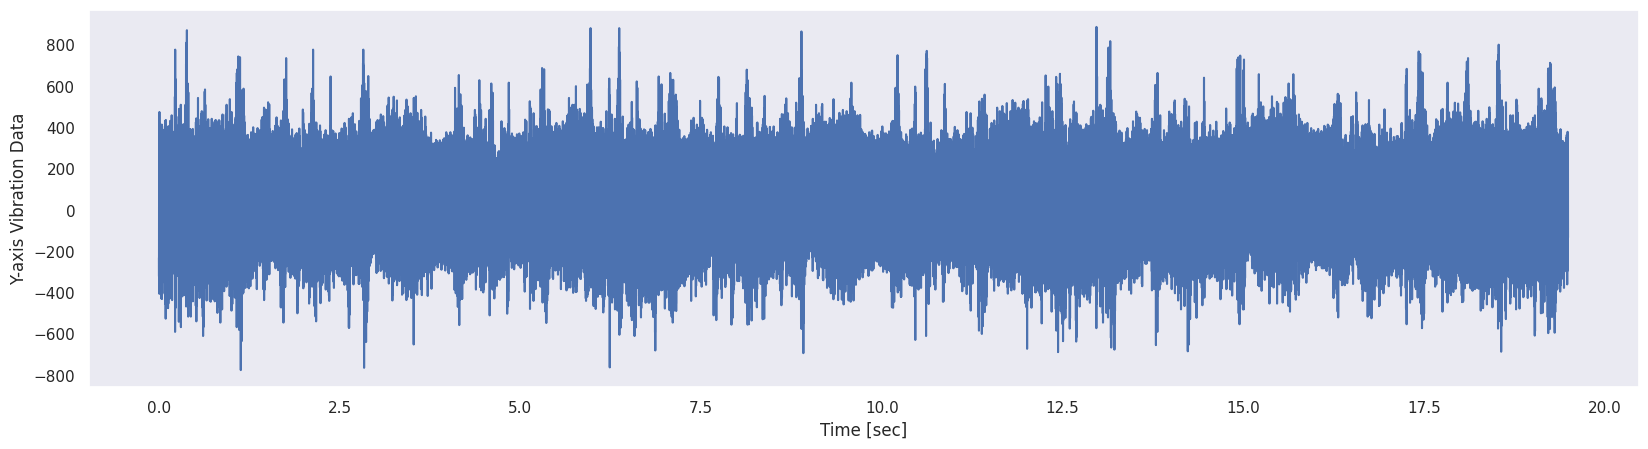

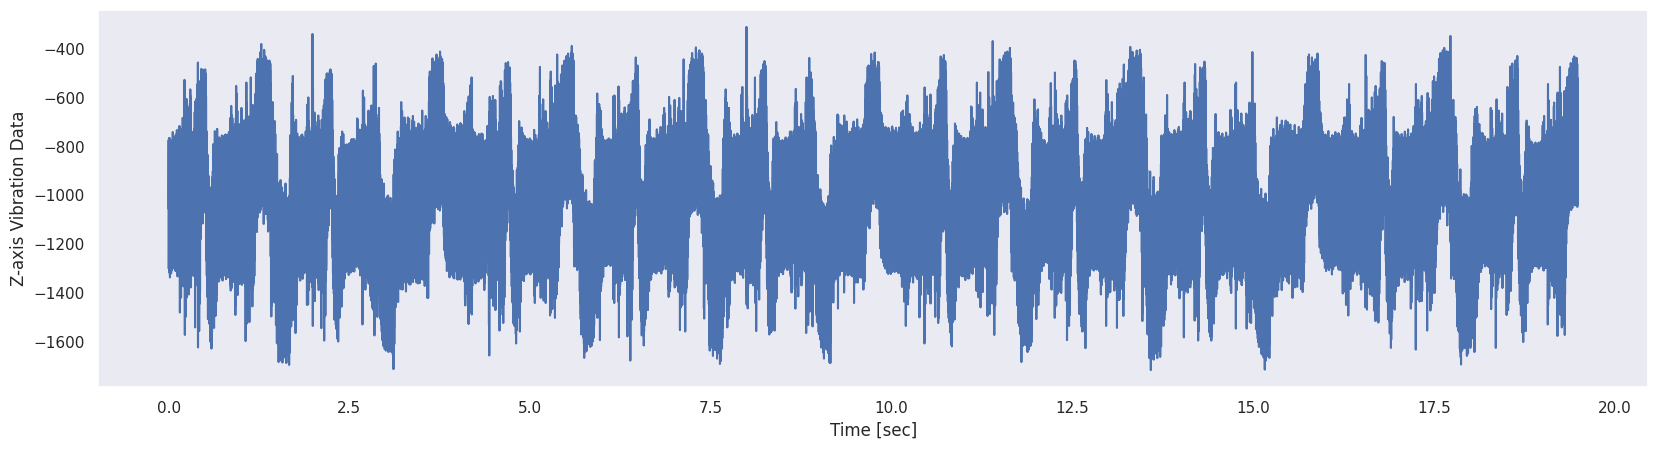

In [16]:
# Time series data of a faulty anamolous signal

file="./data/M01/OP01/bad/M01_Aug_2019_OP01_000.h5"
sample = data_loader_utils.datafile_read(file)

# Data Preprocessing Functions

## Data Padding

In [17]:
# function to add 0s for missing features and values
def data_padding(X_data):
  X_data_arr = np.array(X_data)
  print(f"Shape of Data before padding :  {len(X_data)}")
  m = max(map(len, X_data_arr))
  X_data_arr = np.array([np.pad(x, [(0, m - len(x)),(0,0)], 'constant') for x in X_data_arr])
  print(f"Shape of Data after padding : {X_data_arr.shape}")
  return X_data_arr

## Downsampling Function

In [18]:
# function to downsample the data for a given factor
def downsample_data(downsize_rate, X_data_arr):
  ds_all = pd.DataFrame()
  ds_all = ds_all.to_xarray()
  df_list = []
  print(f"Shape of Data before downsampling :  {len(X_data_arr)}")

  for i in X_data_arr:
    df = pd.DataFrame(i)
    df = df.groupby(np.arange(len(df))//downsize_rate).mean()
    df_list.append(df)

  X_resampled = np.array(df_list)
  print(f"Shape of Data after downsampling :  {len(X_resampled)}")
  return X_resampled

## Data Normalization Function

In [19]:
# function to normalize the given data
def normalize_data(data):
  ds_all = pd.DataFrame()
  ds_all = ds_all.to_xarray()
  df_list = []

  for i in data:
    df = pd.DataFrame(i)
    scaler = MinMaxScaler()
    scaler = scaler.partial_fit(df)
    df = scaler.transform(df)
    df_list.append(df)

  X_resampled = np.array(df_list)
  return X_resampled

# Util Functions

Functions that are used commonly between the models are defined in this section.

In [20]:
# set the params
epochs = 100
batch_size = 100
validation_split = 0.2
shuffle = False
optimizer = 'adam'
loss = 'mse'
metrics = 'accuracy'

# seed the generator
from random import seed
from random import random 
seed(7)

In [21]:
# Autoencoder classes with different layers and dropout rates
class Autoencoder1(Model):
    def __init__(self):
        super(Autoencoder1, self).__init__()
        self.encoder = Sequential([
        Conv1D(filters=128, kernel_size=3, padding="same", strides=1, activation="relu"),
        Dropout(rate=0.5),
        Conv1D(filters=64, kernel_size=3, padding="same", strides=1, activation="relu"),
          ])

        self.decoder = Sequential([
        Conv1DTranspose(filters=64, kernel_size=3, padding="same", strides=1, activation="relu"),
        Dropout(rate=0.5),
        Conv1DTranspose(filters=128, kernel_size=3, padding="same", strides=1, activation="relu"),
        Conv1DTranspose(filters=3, kernel_size=7, padding="same")
          ])


    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [22]:
class Autoencoder2(Model):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        self.encoder = Sequential([
        Conv1D(filters=64, kernel_size=3, padding="same", strides=1, activation="relu"),
        Dropout(rate=0.2),
        Conv1D(filters=32, kernel_size=3, padding="same", strides=1, activation="relu"),
        Conv1D(filters=16, kernel_size=3, padding="same", strides=1, activation="relu"),
          ])

        self.decoder = Sequential([
        Conv1DTranspose(filters=16, kernel_size=3, padding="same", strides=1, activation="relu"),
        Conv1DTranspose(filters=32, kernel_size=3, padding="same", strides=1, activation="relu"),
        Dropout(rate=0.2),
        Conv1DTranspose(filters=64, kernel_size=3, padding="same", strides=1, activation="relu"),
        Conv1DTranspose(filters=3, kernel_size=7, padding="same")
          ])


    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [23]:
class Autoencoder3(Model):
    def __init__(self):
        super(Autoencoder3, self).__init__()
        self.encoder = Sequential([
        # Input(shape=(1094, 3)),
        Conv1D(filters=64, kernel_size=3, padding="same", strides=1, activation="relu"),
        Dropout(rate=0.1),
        Conv1D(filters=32, kernel_size=3, padding="same", strides=1, activation="relu"),
        Conv1D(filters=16, kernel_size=3, padding="same", strides=1, activation="relu"),
          ])

        self.decoder = Sequential([
        Conv1DTranspose(filters=16, kernel_size=3, padding="same", strides=1, activation="relu"),
        Conv1DTranspose(filters=32, kernel_size=3, padding="same", strides=1, activation="relu"),
        Dropout(rate=0.2),
        Conv1DTranspose(filters=64, kernel_size=3, padding="same", strides=1, activation="relu"),
        Conv1DTranspose(filters=3, kernel_size=7, padding="same")
          ])


    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [24]:
# get a list of models to evaluate
def get_models():
	models = dict()
	models['AE Model 1'] = Autoencoder1()
	models['AE Model 2'] = Autoencoder2()
	models['AE Model 3'] = Autoencoder3()
	models['AE Model 4'] = Autoencoder2()
	models['AE Model 5'] = Autoencoder3()

	return models

In [25]:
# Loss Function
def calculate_loss(loss, data_X, recon_X):
  if loss == 'mse':
      total_loss =  np.max(np.mean(np.square(recon_X - data_X),axis=-1), axis=-1)
  elif loss == 'mae':
      total_loss =  np.max(np.mean(np.absolute(recon_X - data_X),axis=-1), axis=-1)

  return total_loss

In [26]:
# Function to fit a given model and  plot the loss
def fit_model(model, train_X,name='Model'):
  model.compile(optimizer='adam', loss='mse', metrics='accuracy')
  history = model.fit(train_X, train_X, epochs = epochs, 
                          batch_size = batch_size, 
                          validation_split = validation_split, 
                          shuffle = shuffle, verbose=1)
    # Get training and test loss histories
  training_loss = history.history['loss']
  test_loss = history.history['val_loss']

  # Create count of the number of epochs
  epoch_count = range(1, len(training_loss) + 1)

  # Visualize loss history
  plt.plot(epoch_count, training_loss, 'r--')
  plt.plot(epoch_count, test_loss, 'b-')
  plt.legend(['Validation Loss', 'Test Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('MSE Loss')
  plt.title(f'Loss v/s Epoch for AE Conv {name}')
  plt.show();
  return model

In [27]:
# Function to evaluate the model on the test data, determine the threshold for 
# anomaly detection and predict those ids 
def evaluate_model_output(model, X_train, X_test, loss):

	# evaluate the model prediction
  _, test_acc = model.evaluate(X_test, X_test)
  reconstruction_test = model.predict(X_test)
  reconstruction_train = model.predict(X_train)

  # calculate error function for threshold
  total_train_loss = calculate_loss(loss, X_train, reconstruction_train)
  total_test_loss = calculate_loss(loss, X_test, reconstruction_test)

  # calculate threshold
  threshold = np.mean(total_train_loss) + 2*np.std(total_train_loss)
  threshold_ids = np.where(total_test_loss > threshold)

  # predict anomaly based on threshold
  pred_output = np.zeros(X_test.shape[0]).astype('int')
  pred_output[threshold_ids] = 1

  return test_acc, threshold, threshold_ids, pred_output

# Individual AutoEncoder using Convolutional Layers

## Data Preprocessing

In [28]:
# Downsample the data for faster training purpose and
# preprocess the raw data
DOWNSAMPLE_RATE = 250
X_data_arr = data_padding(X_data)
X_resampled = downsample_data(DOWNSAMPLE_RATE, X_data_arr)
X_resampled = normalize_data(X_resampled)
print(f"Dataset shape after preprocessing {X_resampled.shape}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


Shape of Data before padding :  1702
Shape of Data after padding : (1702, 317440, 3)
Shape of Data before downsampling :  1702
Shape of Data after downsampling :  1702
Dataset shape after preprocessing (1702, 1270, 3)


## Data Splitting

In [29]:
# Data of Machine 1 and Machine 3 are used for training , where as 
# data of Macine 2 is used for testing.
temp_1 = eda_df.loc[(eda_df['MACHINE'] == 'M01' ) | (eda_df['MACHINE'] == 'M03' )]
temp_2 = eda_df.loc[eda_df['MACHINE'] == 'M02']
train_set_index = temp_1.index.values
test_set_index = temp_2.index.values

X_train =  np.array(list(itemgetter(*train_set_index)(X_resampled)))
y_train =  np.array(list(itemgetter(*train_set_index)(y_data)))
X_test =  np.array(list(itemgetter(*test_set_index)(X_resampled)))
y_test =  np.array(list(itemgetter(*test_set_index)(y_data)))

# Refined prediction values in terms of 0 and 1
gt_all = np.array([1 if 'bad' in i else 0 for i in y_data])
gt_test = np.array([1 if 'bad' in i else 0 for i in y_test])
gt_train = np.array([1 if 'bad' in i else 0 for i in y_train])

## Data Modelling

In [30]:
model = Autoencoder1()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = model.fit(X_train, X_train, epochs = epochs, 
                        batch_size = batch_size, 
                        validation_split = validation_split, 
                        shuffle = shuffle, verbose=1)

Epoch 1/100
9/9 [==============================] - 3s 237ms/step - loss: 0.1795 - accuracy: 0.6100 - val_loss: 0.0184 - val_accuracy: 0.7519
Epoch 2/100
9/9 [==============================] - 2s 192ms/step - loss: 0.0446 - accuracy: 0.6564 - val_loss: 0.0467 - val_accuracy: 0.7519
Epoch 3/100
9/9 [==============================] - 2s 191ms/step - loss: 0.0278 - accuracy: 0.6761 - val_loss: 0.0229 - val_accuracy: 0.8351
Epoch 4/100
9/9 [==============================] - 2s 193ms/step - loss: 0.0182 - accuracy: 0.7870 - val_loss: 0.0188 - val_accuracy: 0.8617
Epoch 5/100
9/9 [==============================] - 2s 194ms/step - loss: 0.0139 - accuracy: 0.8152 - val_loss: 0.0248 - val_accuracy: 0.8623
Epoch 6/100
9/9 [==============================] - 2s 193ms/step - loss: 0.0124 - accuracy: 0.8194 - val_loss: 0.0160 - val_accuracy: 0.8630
Epoch 7/100
9/9 [==============================] - 2s 192ms/step - loss: 0.0112 - accuracy: 0.8209 - val_loss: 0.0183 - val_accuracy: 0.8644
Epoch 8/100
9

## Model Evaluation

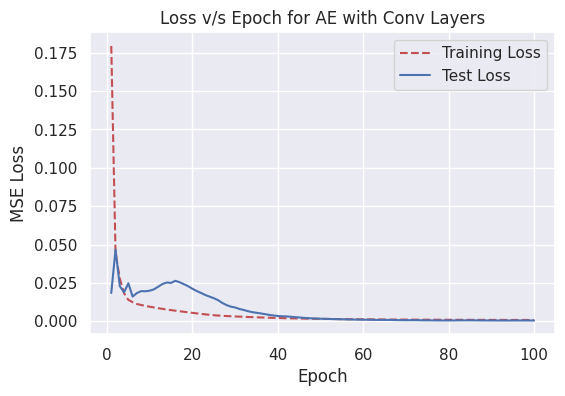

21/21 [==============================] - 1s 25ms/step - loss: 6.6843e-04 - accuracy: 0.9620
Model : name Score : 0.9619565010070801


In [31]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)


# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title("Loss v/s Epoch for AE with Conv Layers")
plt.show();

# evaluate output
score, threshold_val, thresh_ids, pred_output = evaluate_model_output(
    model, X_train, X_test,'mse')
print(f'Model : name Score : {score}')

In [32]:
# Confusion Metrics and its different parameters
f1 = f1_score(gt_test, pred_output)
print('F-Measure: %.3f' % f1)

recall = recall_score(gt_test, pred_output)
print('Recall: %.3f' % recall)

precision = precision_score(gt_test, pred_output)
print('Precision: %.3f' % precision)

roc_auc = roc_auc_score(gt_test, pred_output)
print('ROC-AUC: %.3f' % roc_auc)

FNR = 1 - recall
TNR = recall_score(gt_test, pred_output, pos_label = 0) 
FPR = 1 - TNR
print('False Positive Rate : %.3f' % FPR)
print('False Negative Rate: %.3f' % FNR)

FP = np.sum(np.logical_and(pred_output == 1, gt_test == 0))
FN = np.sum(np.logical_and(pred_output == 0, gt_test == 1))

print(classification_report(gt_test, pred_output))


F-Measure: 0.720
Recall: 0.667
Precision: 0.783
ROC-AUC: 0.829
False Positive Rate : 0.008
False Negative Rate: 0.333
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       617
           1       0.78      0.67      0.72        27

    accuracy                           0.98       644
   macro avg       0.88      0.83      0.85       644
weighted avg       0.98      0.98      0.98       644



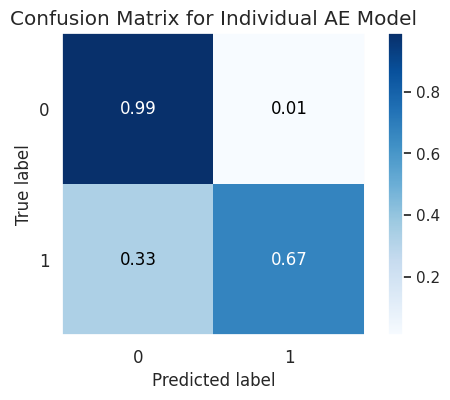

In [33]:
skplt.metrics.plot_confusion_matrix(gt_test, pred_output, normalize=True, title = 'Confusion Matrix for Individual AE Model')

In [34]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(gt_test, pred_output, pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(gt_test.ravel(), pred_output.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

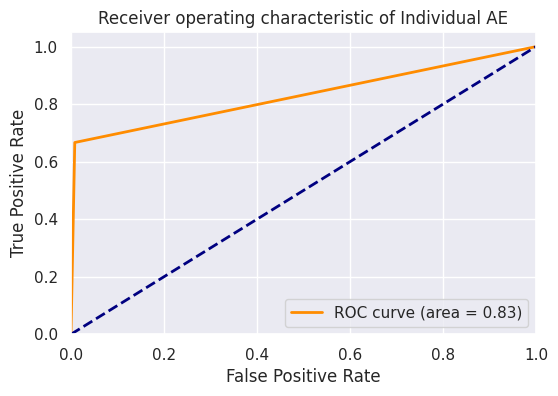

In [35]:
plt.figure()
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic of Individual AE")
plt.legend(loc="lower right")
plt.show()

# Stacking Ensemble of AE

## Data Splitting

In [36]:
# Data of Machine 1 and Machine 3 are used for training , where as 
# data of Macine 2 is used for testing.

temp_1 = eda_df.loc[(eda_df['MACHINE'] == 'M01' ) | (eda_df['MACHINE'] == 'M03' )]
temp_2 = eda_df.loc[eda_df['MACHINE'] == 'M02']
train_set_index = temp_1.index.values
test_set_index = temp_2.index.values

X_train =  np.array(list(itemgetter(*train_set_index)(X_resampled)))
y_train =  np.array(list(itemgetter(*train_set_index)(y_data)))
X_test =  np.array(list(itemgetter(*test_set_index)(X_resampled)))
y_test =  np.array(list(itemgetter(*test_set_index)(y_data)))

train_half_val = int(X_train.shape[0] /2)
test_half_val = int(X_test.shape[0] /2)

# Half of the training and testing data is used to 
# train level 0 models and other other for level 1 model 
X_train_level_0 = X_train[:train_half_val,:,:]
y_train_level_0 = y_train[:train_half_val]
X_test_level_0 = X_test[:test_half_val,:,:]
y_test_level_0 = y_test[:test_half_val]

X_train_level_1 = X_train[train_half_val:,:,:]
y_train_level_1 = y_train[train_half_val:]
X_test_level_1 = X_test[test_half_val:,:,:]
y_test_level_1 = y_test[test_half_val:]


gt_all = np.array([1 if 'bad' in i else 0 for i in y_data])
gt_test = np.array([1 if 'bad' in i else 0 for i in y_test])
gt_train = np.array([1 if 'bad' in i else 0 for i in y_train])

gt_test_level_0 = gt_test[:test_half_val]
gt_train_level_0 =  gt_train[:train_half_val]

gt_test_level_1 = gt_test[test_half_val:]
gt_train_level_1 =  gt_train[train_half_val:]

## Sub-model Training or Level-0 Modelling

Epoch 1/100
5/5 [==============================] - 2s 239ms/step - loss: 0.2077 - accuracy: 0.2822 - val_loss: 0.0418 - val_accuracy: 0.7880
Epoch 2/100
5/5 [==============================] - 1s 186ms/step - loss: 0.0680 - accuracy: 0.6363 - val_loss: 0.0671 - val_accuracy: 0.6234
Epoch 3/100
5/5 [==============================] - 1s 181ms/step - loss: 0.0564 - accuracy: 0.6443 - val_loss: 0.0628 - val_accuracy: 0.6234
Epoch 4/100
5/5 [==============================] - 1s 182ms/step - loss: 0.0336 - accuracy: 0.6449 - val_loss: 0.0178 - val_accuracy: 0.6236
Epoch 5/100
5/5 [==============================] - 1s 181ms/step - loss: 0.0287 - accuracy: 0.6788 - val_loss: 0.0412 - val_accuracy: 0.7924
Epoch 6/100
5/5 [==============================] - 1s 181ms/step - loss: 0.0230 - accuracy: 0.7599 - val_loss: 0.0218 - val_accuracy: 0.7921
Epoch 7/100
5/5 [==============================] - 1s 183ms/step - loss: 0.0174 - accuracy: 0.7765 - val_loss: 0.0258 - val_accuracy: 0.7926
Epoch 8/100
5

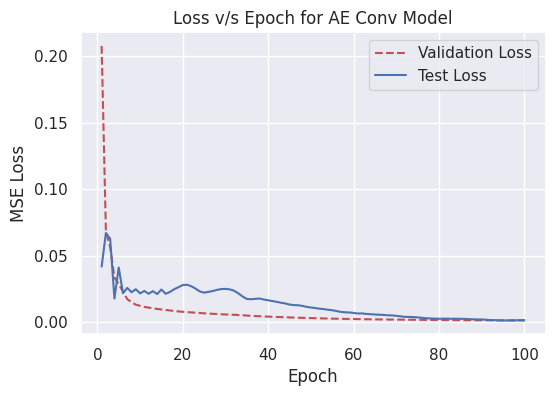

11/11 [==============================] - 0s 24ms/step - loss: 0.0018 - accuracy: 0.9511
Model : AE Model 1 Score : 0.9510833024978638
>AE Model 1 0.951 (0.000)
Epoch 1/100
5/5 [==============================] - 2s 150ms/step - loss: 0.3177 - accuracy: 0.5134 - val_loss: 0.1797 - val_accuracy: 0.6224
Epoch 2/100
5/5 [==============================] - 0s 89ms/step - loss: 0.0989 - accuracy: 0.6266 - val_loss: 0.0443 - val_accuracy: 0.6234
Epoch 3/100
5/5 [==============================] - 0s 87ms/step - loss: 0.0714 - accuracy: 0.6434 - val_loss: 0.0238 - val_accuracy: 0.6234
Epoch 4/100
5/5 [==============================] - 0s 87ms/step - loss: 0.0342 - accuracy: 0.6442 - val_loss: 0.0497 - val_accuracy: 0.6234
Epoch 5/100
5/5 [==============================] - 0s 87ms/step - loss: 0.0434 - accuracy: 0.6442 - val_loss: 0.0327 - val_accuracy: 0.6234
Epoch 6/100
5/5 [==============================] - 0s 89ms/step - loss: 0.0309 - accuracy: 0.6442 - val_loss: 0.0246 - val_accuracy: 0.6234

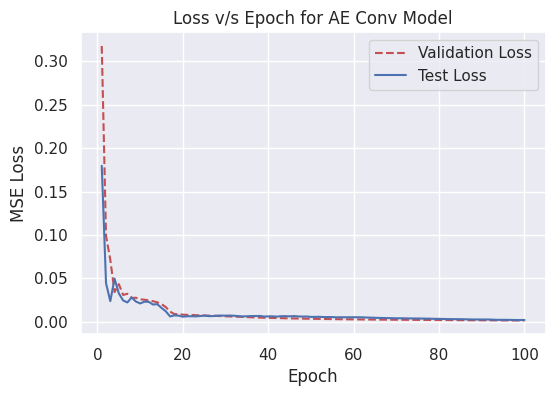

11/11 [==============================] - 0s 14ms/step - loss: 0.0025 - accuracy: 0.9333
Model : AE Model 2 Score : 0.9333349466323853
>AE Model 2 0.933 (0.000)
Epoch 1/100
5/5 [==============================] - 2s 148ms/step - loss: 0.3684 - accuracy: 0.1973 - val_loss: 0.2685 - val_accuracy: 0.1983
Epoch 2/100
5/5 [==============================] - 0s 90ms/step - loss: 0.1856 - accuracy: 0.1793 - val_loss: 0.0730 - val_accuracy: 0.2012
Epoch 3/100
5/5 [==============================] - 0s 89ms/step - loss: 0.0759 - accuracy: 0.3980 - val_loss: 0.0270 - val_accuracy: 0.6234
Epoch 4/100
5/5 [==============================] - 0s 93ms/step - loss: 0.0379 - accuracy: 0.6442 - val_loss: 0.0513 - val_accuracy: 0.6234
Epoch 5/100
5/5 [==============================] - 0s 91ms/step - loss: 0.0495 - accuracy: 0.6443 - val_loss: 0.0368 - val_accuracy: 0.6234
Epoch 6/100
5/5 [==============================] - 0s 92ms/step - loss: 0.0367 - accuracy: 0.6443 - val_loss: 0.0250 - val_accuracy: 0.6234

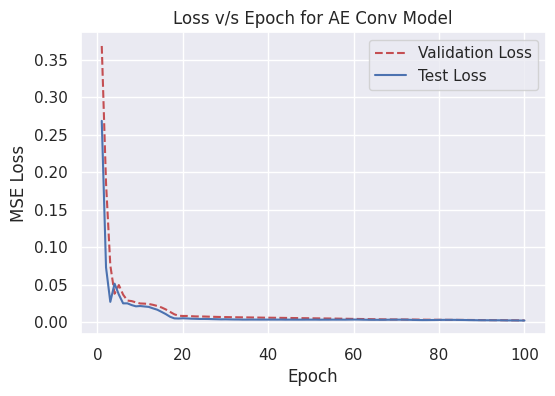

11/11 [==============================] - 0s 14ms/step - loss: 0.0021 - accuracy: 0.9294
Model : AE Model 3 Score : 0.9293710589408875
>AE Model 3 0.929 (0.000)
Epoch 1/100
5/5 [==============================] - 2s 155ms/step - loss: 0.3265 - accuracy: 0.2217 - val_loss: 0.1818 - val_accuracy: 0.1740
Epoch 2/100
5/5 [==============================] - 0s 92ms/step - loss: 0.1073 - accuracy: 0.2574 - val_loss: 0.0531 - val_accuracy: 0.6219
Epoch 3/100
5/5 [==============================] - 0s 93ms/step - loss: 0.0570 - accuracy: 0.6255 - val_loss: 0.0302 - val_accuracy: 0.6234
Epoch 4/100
5/5 [==============================] - 0s 94ms/step - loss: 0.0394 - accuracy: 0.6442 - val_loss: 0.0481 - val_accuracy: 0.6234
Epoch 5/100
5/5 [==============================] - 0s 91ms/step - loss: 0.0391 - accuracy: 0.6443 - val_loss: 0.0282 - val_accuracy: 0.6234
Epoch 6/100
5/5 [==============================] - 0s 95ms/step - loss: 0.0338 - accuracy: 0.6443 - val_loss: 0.0205 - val_accuracy: 0.6234

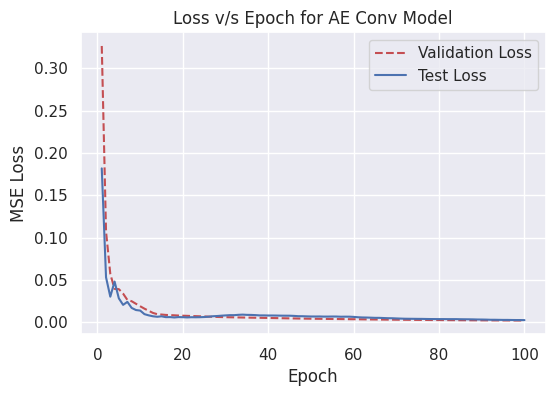

11/11 [==============================] - 0s 14ms/step - loss: 0.0029 - accuracy: 0.9358
Model : AE Model 4 Score : 0.9357925653457642
>AE Model 4 0.936 (0.000)
Epoch 1/100
5/5 [==============================] - 2s 160ms/step - loss: 0.2938 - accuracy: 0.1804 - val_loss: 0.1216 - val_accuracy: 0.2033
Epoch 2/100
5/5 [==============================] - 0s 98ms/step - loss: 0.0894 - accuracy: 0.2450 - val_loss: 0.0436 - val_accuracy: 0.6243
Epoch 3/100
5/5 [==============================] - 0s 97ms/step - loss: 0.0392 - accuracy: 0.6380 - val_loss: 0.0430 - val_accuracy: 0.6234
Epoch 4/100
5/5 [==============================] - 0s 93ms/step - loss: 0.0467 - accuracy: 0.6443 - val_loss: 0.0469 - val_accuracy: 0.6234
Epoch 5/100
5/5 [==============================] - 0s 96ms/step - loss: 0.0407 - accuracy: 0.6443 - val_loss: 0.0282 - val_accuracy: 0.6234
Epoch 6/100
5/5 [==============================] - 0s 95ms/step - loss: 0.0309 - accuracy: 0.6443 - val_loss: 0.0227 - val_accuracy: 0.6234

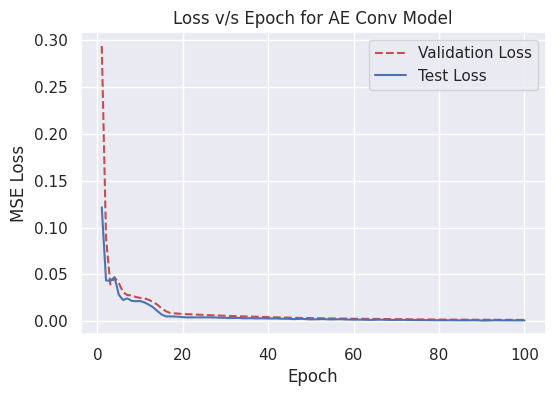

11/11 [==============================] - 0s 14ms/step - loss: 9.6636e-04 - accuracy: 0.9413
Model : AE Model 5 Score : 0.9412921071052551
>AE Model 5 0.941 (0.000)


In [37]:
# evaluate the models and store models in the file
models = get_models()
results, pred_outputs = list(), list()
t_ids = list()
threshold_values = list()

for name, model in models.items():
  # fit the model
  model = fit_model(model, X_train_level_0)

  # save the model
  filename = 'models/model_' + name + '.tf'
  model.save(filename, save_format="tf")

  # evaluate output
  score, threshold_val, thresh_ids, pred_output = evaluate_model_output(
      model, X_train_level_0, X_test_level_0,'mse')
  print(f'Model : {name} Score : {score}')
  
  results.append(score)
  threshold_values.append(threshold_val)
  pred_outputs.append(pred_output)
  t_ids.append(np.array(thresh_ids).flatten())
  print('>%s %.3f (%.3f)' % (name, np.mean(score), np.std(score)))

## Meta Learner Training or Level-1 Modelling

In [38]:
from keras.models import load_model

# load models from file
def load_all_models():
  models = list()
  all_models = get_models()
  for name in all_models.keys():
		# define filename for this ensemble
    filename = 'models/model_' + name + '.tf'
		# load model from file
    model = load_model(filename)
		# add to list of members
    models.append(model)
    print('>loaded %s' % filename)
  return models

In [39]:
from numpy import dstack, vstack, hstack

# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
  stackX = None
  i = 0
  for model in members:
    # calculate error function and threshold ids
    reconstruction_test = model.predict(inputX)
    total_test_loss = calculate_loss('mse', inputX, reconstruction_test)
    threshold_ids = np.where(total_test_loss > threshold_values[i])
    i+=1

    # predict anomaly based on threshold
    yhat = np.zeros(inputX.shape[0]).astype('int')
    yhat[threshold_ids] = 1
    yhat = yhat.reshape(yhat.shape[0],1)

    # stack predictions into [rows, members, probabilities]
    if stackX is None:
      stackX = yhat
    else:
      stackX = dstack((stackX, yhat))

  # flatten predictions to [rows, members x probabilities]
  
  stackX_re = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
  return stackX_re


In [40]:
def fit_stacked_model(members, inputX, inputy):
  # create dataset using ensemble
  stackedX = stacked_dataset(members, inputX)
  # fit standalone model
  model = Sequential()
  model.add(Dense(20, input_shape=(len(members),), activation="relu"))
  model.add(Dense(2,activation="softmax"))
  model.compile(optimizer='adam', loss='mse', metrics='accuracy')
  model.fit(stackedX, inputy, epochs=50)
  return model

In [41]:
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
  # create dataset using ensemble
  stackedX = stacked_dataset(members, inputX)
  print(stackedX.shape)
  # make a prediction
  yhat = model.predict(stackedX)
  return yhat

In [42]:

from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

members = load_all_models()
print('Loaded %d models' % len(members))
# evaluate standalone models on test dataset
for model in members:
  _, acc = model.evaluate(X_test_level_0, X_test_level_0, verbose=0)
  print('Model Accuracy: %.3f' % acc)

testy_enc = to_categorical(gt_train_level_1).astype('int')
# fit stacked model using the ensemble
model = fit_stacked_model(members, X_train_level_1, testy_enc)
# # evaluate model on test set
yhat_orig = stacked_prediction(members, model, X_test_level_1)
yhat = np.where(yhat_orig > 0.5, 1,0)

# Converting the results to binary 
pred_outputs = argmax(yhat, axis=1)
acc = accuracy_score(gt_test_level_1, pred_outputs)
print('Stacked Test Accuracy: %.3f' % acc)

>loaded models/model_AE Model 1.tf
>loaded models/model_AE Model 2.tf
>loaded models/model_AE Model 3.tf
>loaded models/model_AE Model 4.tf
>loaded models/model_AE Model 5.tf
Loaded 5 models
Model Accuracy: 0.951
Model Accuracy: 0.933
Model Accuracy: 0.929
Model Accuracy: 0.936
Model Accuracy: 0.941
Epoch 1/50
17/17 [==============================] - 0s 2ms/step - loss: 0.2423 - accuracy: 0.9509
Epoch 2/50
17/17 [==============================] - 0s 1ms/step - loss: 0.2228 - accuracy: 0.9679
Epoch 3/50
17/17 [==============================] - 0s 1ms/step - loss: 0.2023 - accuracy: 0.9660
Epoch 4/50
17/17 [==============================] - 0s 1ms/step - loss: 0.1806 - accuracy: 0.9603
Epoch 5/50
17/17 [==============================] - 0s 1ms/step - loss: 0.1588 - accuracy: 0.9660
Epoch 6/50
17/17 [==============================] - 0s 1ms/step - loss: 0.1378 - accuracy: 0.9716
Epoch 7/50
17/17 [==============================] - 0s 1ms/step - loss: 0.1179 - accuracy: 0.9716
Epoch 8/50
17

## Model Evaluation

In [43]:
# Uising confusion matrix to evaluate model performance
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, classification_report

f1 = f1_score(gt_test_level_1, pred_outputs)

print('F-Measure: %.3f' % f1)

recall = recall_score(gt_test_level_1, pred_outputs)
print('Recall: %.3f' % recall)

precision = precision_score(gt_test_level_1, pred_outputs)
print('Precision: %.3f' % precision)

roc_auc = roc_auc_score(gt_test_level_1, pred_outputs)
print('ROC-AUC: %.3f' % roc_auc)

print(classification_report(gt_test_level_1, pred_outputs))

F-Measure: 0.846
Recall: 0.733
Precision: 1.000
ROC-AUC: 0.867
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       307
           1       1.00      0.73      0.85        15

    accuracy                           0.99       322
   macro avg       0.99      0.87      0.92       322
weighted avg       0.99      0.99      0.99       322



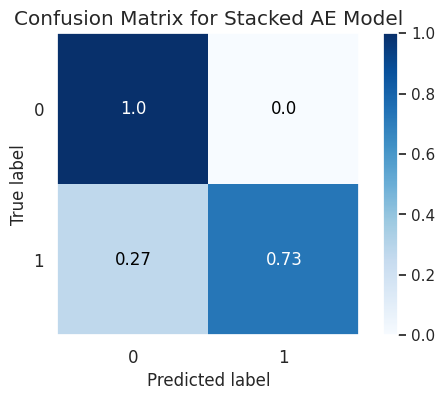

In [44]:
skplt.metrics.plot_confusion_matrix(gt_test_level_1, pred_outputs, normalize=True, title = 'Confusion Matrix for Stacked AE Model')

In [45]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(gt_test_level_1, pred_outputs, pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(gt_test_level_1.ravel(), pred_outputs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

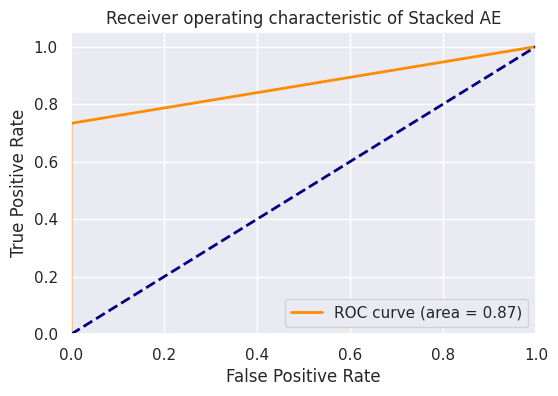

In [48]:
plt.figure()
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic of Stacked AE")
plt.legend(loc="lower right")
plt.show()